In [114]:
import math
import sympy as sym
import numpy as np
from sympy.physics.quantum.tensorproduct import TensorProduct

# CHSH

$$
\begin{align}
S_{CHSH} & = X \otimes \left(Y + Y' \right) + X' \otimes (Y - Y') \\
& = \vec{a} \cdot \vec{\sigma} \otimes \left(\vec{b}\cdot \vec{\sigma} + \vec{b'} \cdot \vec{\sigma} \right) 
+ \vec{a'} \cdot \vec{\sigma} \otimes (\vec{b} \cdot \vec{\sigma} - \vec{b'} \cdot \vec{\sigma})
\end{align}
$$

where $\vec{a},\vec{b}, \vec{a'}, \vec{b'} \in \mathbb{R}^3$ and $|\vec{a}| = |\vec{b}| = |\vec{a'}| = |\vec{b'}| = 1$ .

In [2]:
def build_measure(phi: sym.Symbol, rho: sym.Symbol) -> sym.Matrix:
    """
    Construct a Pauli measurement given a unit 3-D vector `(phi, rho)`.
    The unit vector is (cos(phi) * cos(rho), cos(phi) * sin(rho), sin(phi)).
    """

    # Pauli matrices
    X = sym.Matrix([[0, 1], [1, 0]])
    Y = sym.Matrix([[0, -1j], [1j, 0]])
    Z = sym.Matrix([[1, 0], [0, -1]])

    # unit vector
    a = sym.cos(phi) * sym.cos(rho) # type: ignore
    b = sym.cos(phi) * sym.sin(rho) # type: ignore
    c = sym.sin(phi)

    return a * X + b * Y + c * Z

In [3]:
def get_CHSH():
    # Alice
    phi_1, rho_1 = sym.symbols(("phi^1_1:3", "rho^1_1:3"), real=True) # type: ignore
    # Bob
    phi_2, rho_2 = sym.symbols(("phi^2_1:3", "rho^2_1:3"), real=True) # type: ignore

    X_1 = build_measure(phi_1[0], rho_1[0])
    Y_1 = build_measure(phi_1[1], rho_1[1])
    X_2 = build_measure(phi_2[0], rho_2[0])
    Y_2 = build_measure(phi_2[1], rho_2[1])

    S_chsh = TensorProduct(X_1, Y_1 + Y_2) + TensorProduct(X_2, Y_1 - Y_2) # type: ignore
    return S_chsh

In [4]:
S_chsh = get_CHSH()

$$S(\rho) \equiv \max_{S} tr(S\rho)$$

In [5]:
def get_expectation(Rho: sym.Matrix, S: sym.Matrix):
    """
    Calculate $tr(S * Rho)$
    """
    return -(S * Rho).trace()

In [6]:
def get_gradient(e):
    return {p: sym.simplify(e.diff(p)) for p in e.free_symbols}

In [158]:
def optimizer_GCD(Rho, S, step=0.01, MAXEPOCH=100) -> float:
    e = get_expectation(Rho, S)
    (e, _) = e.as_real_imag()
    e = sym.simplify(e)
    g = get_gradient(e)

    num_params = len(g)
    p_name = list(e.free_symbols)

    def cal(expr, x):
        return expr.subs({p: x[i] for (i, p) in enumerate(p_name)})
    
    def cal_dx(x):
        return [cal(g[p], x) for p in p_name]
    
    # init random
    x = np.random.uniform(0, 2 * np.pi, size=(num_params,))
    dx = np.array(cal_dx(x), dtype=np.float32)
    y = x - step * dx

    epoch = 0
    while np.linalg.norm(dx) > 1e-5 and epoch < MAXEPOCH:
        # if epoch % 10 == 0:
        #     print(f"epoch={epoch:3}, e = {cal(e, x)}")
        x = y
        dx = np.array(cal_dx(x), dtype=np.float32)
        y = x - step * dx
        epoch += 1
    
    return -cal(e, x)


$$|\psi\rangle = \frac{|01\rangle - |10\rangle}{\sqrt{2}}$$

$$
\rho = |\psi\rangle \langle \psi| 
= \frac{1}{2} \begin{bmatrix} 0 \\ -1 \\ 1 \\ 0\end{bmatrix} 
\begin{bmatrix} 0 & -1 & 1 & 0  \end{bmatrix}
= \frac{1}{2} \begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 1 & -1 & 0 \\
0 & -1 & 1 & 0 \\
0 & 0 & 0 & 0
\end{bmatrix}
$$

In [8]:
Rho = 1 / 2 * sym.Matrix([[0, 0, 0, 0], [0, 1, -1, 0], [0, -1, 1, 0], [0, 0, 0, 0]])
Rho

Matrix([
[0,    0,    0, 0],
[0,  0.5, -0.5, 0],
[0, -0.5,  0.5, 0],
[0,    0,    0, 0]])

In [131]:
optimizer_GCD(Rho, S_chsh, MAXEPOCH=100000)

epoch=  0, e = 0.0244184614934403
epoch=  1, e = -0.0153277864308967
epoch=  2, e = -0.0551142463970924
epoch=  3, e = -0.0949242506252271
epoch=  4, e = -0.134740745156691
epoch=  5, e = -0.174546312677314
epoch=  6, e = -0.214323203838523
epoch=  7, e = -0.254053367430661
epoch=  8, e = -0.293718486379216
epoch=  9, e = -0.333300010615474
epoch= 10, e = -0.372779206385256
epoch= 11, e = -0.412137197486194
epoch= 12, e = -0.451355012836500
epoch= 13, e = -0.490413633317405
epoch= 14, e = -0.529294051725992
epoch= 15, e = -0.567977317777083
epoch= 16, e = -0.606444602234336
epoch= 17, e = -0.644677247329974
epoch= 18, e = -0.682656824209037
epoch= 19, e = -0.720365194346779
epoch= 20, e = -0.757784559604598
epoch= 21, e = -0.794897525280952
epoch= 22, e = -0.831687147619260
epoch= 23, e = -0.868136993090683
epoch= 24, e = -0.904231185951059
epoch= 25, e = -0.939954453620583
epoch= 26, e = -0.975292178119083
epoch= 27, e = -1.01023043171886
epoch= 28, e = -1.04475601777230
epoch= 29, e 

In [50]:
(np.sqrt(2) * 2)

2.8284271247461903

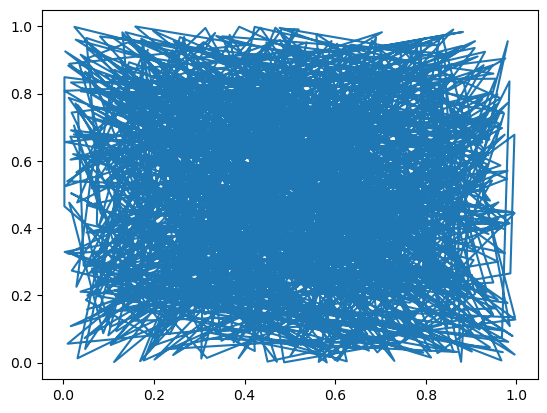

In [12]:
# test numpy random

import matplotlib.pyplot as plt

data = np.random.random(size=(1000, 2))
xs = data[:, 0]
ys = data[:, 1]
plt.plot(xs, ys)

In [19]:
def rand_state(n: int) -> np.ndarray:
    d = 2**n
    state = np.random.random(size=(d,))
    norm = np.linalg.norm(state)
    state = state / norm
    return state

In [45]:
def rand_density_matrix(n: int, r: int) -> sym.Matrix:
    d = 2**n
    rho = sym.matrices.zeros(d, d)
    probabilities = np.random.random(size=(r, ))
    probabilities /= probabilities.sum()
    # print(f"ps = {probabilities}")

    for (_, p) in zip(range(r), probabilities):
        state = rand_state(n)
        state = sym.Matrix(state)
        rho = rho + p * state * state.adjoint()
    
    return rho

$$
\rho = \frac{1}{4}  \left( I \otimes I + \vec{r} \cdot \vec{\sigma} \otimes I + I \otimes \vec{s} \cdot \vec{\sigma} + 
\sum_{n, m = 1}^3 t_{nm} \sigma_n \otimes \sigma_m \right)
$$

where $t_{nm} = Tr(\rho \sigma_n\otimes \sigma_m) \in \Re$. Let matrix $T_\rho = [t_{nm}] \in \Re^{3\times 3}$ .

$$
\max_{\vec{a}, \vec{a'}, \vec{b}, \vec{b'}} Tr(\rho S_{\text{CHSH}}) = 2\sqrt{M(\rho)} 
$$

where

$$
M(\rho) = \max_{\vec{c}, \vec{c'}} \left( \Vert T_\rho \vec{c} \Vert^2 + \Vert T_\rho \vec{c'} \Vert^2 \right)
 = u + \tilde{u}
$$

where

$u, \tilde{u}$ are two greater positive eigenvalues of $U_\rho = T_\rho^T T_\rho$ .

In [161]:
def CHSH_max(rho: sym.Matrix) -> float:
    X = sym.Matrix([[0, 1], [1, 0]])
    Y = sym.Matrix([[0, -1j], [1j, 0]])
    Z = sym.Matrix([[1, 0], [0, -1]])
    sigma = [X, Y, Z]
    T = [[(rho * TensorProduct(sigma[i], sigma[j])).trace() for j in range(3)] for i in range(3)]
    T = sym.Matrix(T)
    (T, _) = T.as_real_imag()
    U = T.transpose() * T
    es = U.eigenvals(multiple=True)
    es.sort(reverse=True)
    return 2 * math.sqrt(es[0] + es[1])

In [120]:
CHSH_max(Rho)

2.8284271247461903

In [163]:
for i in range(20):
    test_rho = rand_density_matrix(2, 2)
    print(f"rand {i: 2} : CHSH max = {CHSH_max(test_rho)}")
    print(f"               opt = {optimizer_GCD(test_rho, S_chsh, 0.1, 1000)}")

rand  0 : CHSH max = 0.9629631846514223
               opt = 0.943716578262567
rand  1 : CHSH max = 1.9117345130366346
               opt = 1.91173448090756
rand  2 : CHSH max = 1.6850051923011329
               opt = 1.68500519207255
rand  3 : CHSH max = 1.9305531178668989
               opt = 1.93041600549790
rand  4 : CHSH max = 2.128411082689082
               opt = 2.11891931953038
rand  5 : CHSH max = 2.0218761727230548
               opt = 2.02138746266542
rand  6 : CHSH max = 2.0687964166245956
               opt = 2.06349646550349
rand  7 : CHSH max = 2.173207037517173
               opt = 2.16971071329319
rand  8 : CHSH max = 2.466411351286561
               opt = 2.46616856412368
rand  9 : CHSH max = 1.7701087086269975
               opt = 1.77010870823650
rand  10 : CHSH max = 2.086520472539761
               opt = 2.08588974721206
rand  11 : CHSH max = 1.9159776043628791
               opt = 1.91595504745610
rand  12 : CHSH max = 1.6963639423715764
               opt = 1.6